# CV: Road Marking Detection

## Installing Requirements

In [ ]:
%pip install opencv-python
%pip install matplotlib
%pip install scikit-learn

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Loading and Transforming Image

In [7]:
def show_image(image, title=None, cmap=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap=cmap)
    plt.title(title or "")
    plt.axis('off')
    plt.show()

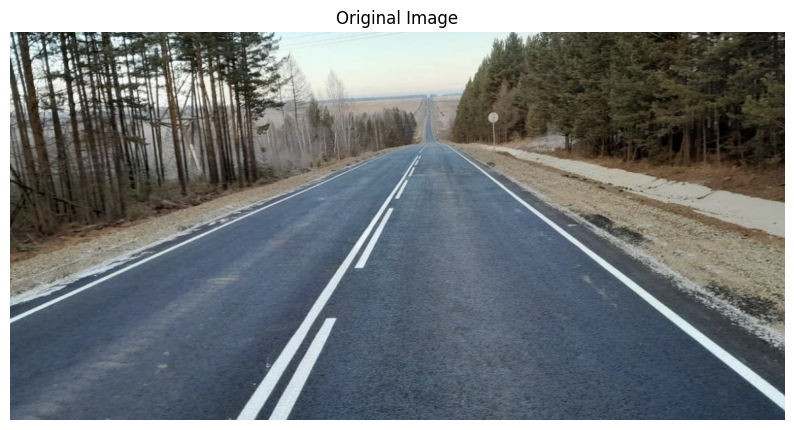

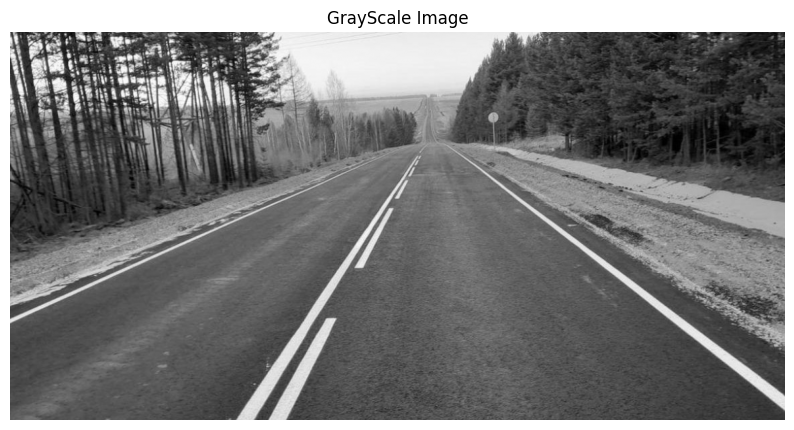

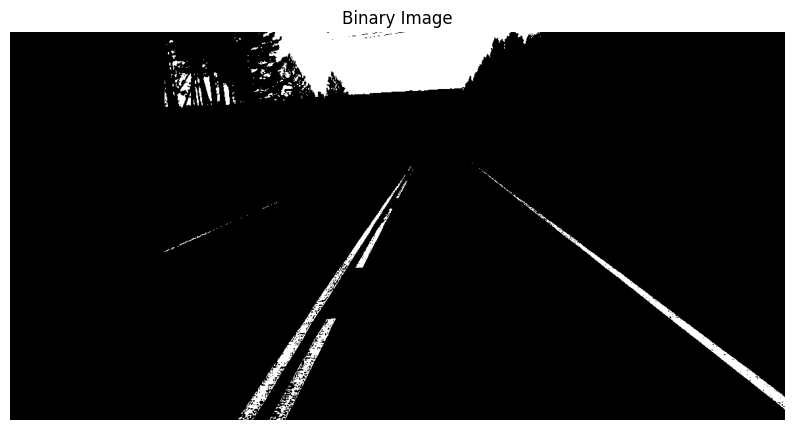

In [ ]:
original_img = cv2.imread("assets/road1.png", cv2.COLOR_BGR2RGB)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY) # convert the image to grayscale, as Hough Transform works on grayscale images

ret, thresh = cv2.threshold(gray_img , 220, 255, cv2.THRESH_BINARY) # changed the min threshold value from 127 to 220, which leads to strictly binarization

binary_img = np.zeros_like(thresh)
start_idx = int(thresh.shape[1] * 0.2)
binary_img[:, start_idx:] = thresh[:, start_idx:]

show_image(original_img, title = "Original Image")
show_image(gray_img, title = "GrayScale Image", cmap="gray")
show_image(binary_img, title = "Binary Image", cmap="gray")

### Applying the Hough Line Transform to detect lines in an image

In [ ]:
lines = cv2.HoughLines(binary_img ,10, np.pi/200, 3900) # very high value of accumulator threshold is explainde by targeting very prominent and well-defined lines in our case as the lane markings
out_image = original_img.copy()

if lines is not None:
    print("Lines were found")
    for line in lines:
        print(line)
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
        cv2.line(out_image, (x1, y1), (x2, y2), (255, 0, 0), 3)

Lines were found
[[-265.          2.214823]]
[[-295.          2.246239]]
[[-245.          2.199115]]
[[-315.          2.261947]]
[[6.150000e+02 5.811947e-01]]


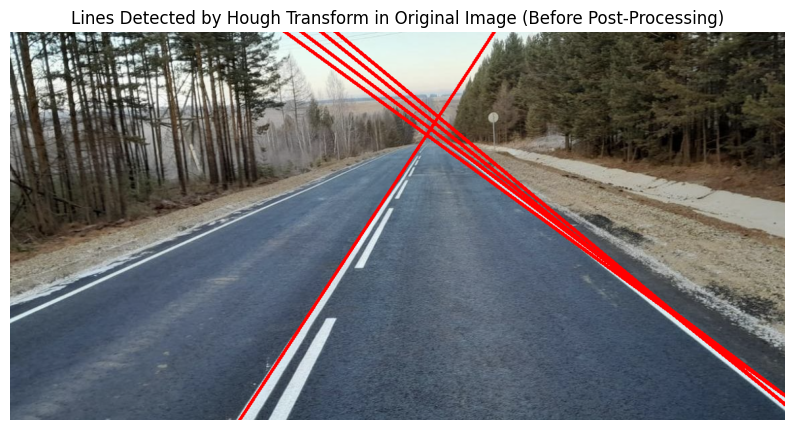

In [11]:
show_image(out_image, title="Lines Detected by Hough Transform in Original Image (Before Post-Processing)")

**Note**: Since the detected set of lines may not consist of exactly two lines—one representing the right lane marking and the other the left—it is crucial to group the lines into two clusters (using K-Means here) and take the centroid of each cluster as the predicted lane marking.

## Post-Processing: K-means Clustering

In [24]:
from sklearn.cluster import KMeans
out_image = original_img.copy()

all_lines = np.array([line[0] for line in lines])
kmeans = KMeans(n_clusters=2, random_state=24).fit(all_lines)
cluster_centers = kmeans.cluster_centers_

average_lines = [[[rho, theta]] for rho, theta in cluster_centers]

for line in average_lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 2000 * (-b))
    y1 = int(y0 + 2000 * (a))
    x2 = int(x0 - 2000 * (-b))
    y2 = int(y0 - 2000 * (a))
    cv2.line(out_image, (x1, y1), (x2, y2), (255, 0, 0), 10)


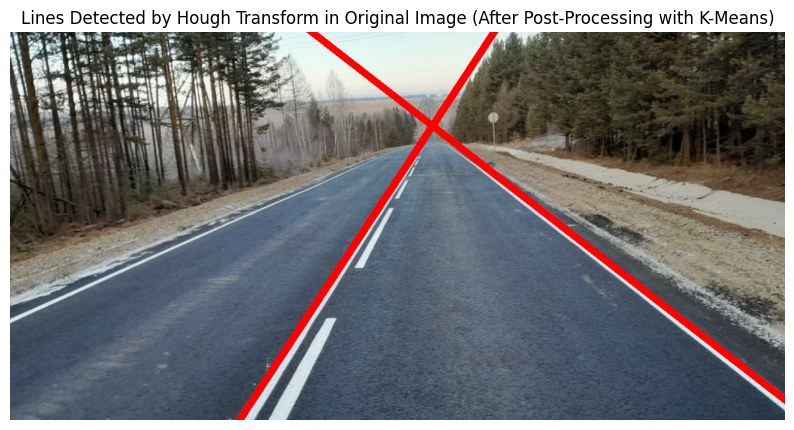

In [25]:
show_image(out_image, title="Lines Detected by Hough Transform in Original Image (After Post-Processing with K-Means)")

## Finding Intersection Point of Lane Marking

In [26]:
def find_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]

    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    intersection = np.linalg.solve(A, b)
    x = int(intersection[0, 0]) 
    y = int(intersection[1, 0])
    return x, y

In [27]:
intersection = find_intersection(average_lines[0], average_lines[1])
print(f"The intersection point: {intersection}")
cv2.circle(out_image, (intersection[0], intersection[1]), 10, (0, 0, 255), -1)

The intersection point: (641, 143)


array([[[103, 126, 133],
        [ 46,  66,  74],
        [ 31,  51,  59],
        ...,
        [ 50,  47,  42],
        [ 34,  31,  26],
        [ 26,  23,  18]],

       [[106, 129, 137],
        [ 51,  69,  80],
        [ 34,  52,  63],
        ...,
        [ 42,  39,  34],
        [ 23,  21,  16],
        [ 20,  17,  12]],

       [[126, 148, 157],
        [ 75,  92, 105],
        [ 41,  58,  70],
        ...,
        [ 51,  48,  43],
        [ 44,  42,  37],
        [ 42,  39,  35]],

       ...,

       [[ 82,  96, 112],
        [ 82,  96, 111],
        [ 81,  95, 110],
        ...,
        [ 39,  56,  71],
        [ 39,  58,  72],
        [ 39,  58,  72]],

       [[ 80,  94, 109],
        [ 79,  93, 108],
        [ 78,  93, 107],
        ...,
        [ 39,  56,  70],
        [ 39,  58,  70],
        [ 40,  58,  71]],

       [[ 79,  93, 109],
        [ 79,  93, 108],
        [ 79,  94, 108],
        ...,
        [ 41,  58,  72],
        [ 41,  60,  71],
        [ 41,  60,  72]]

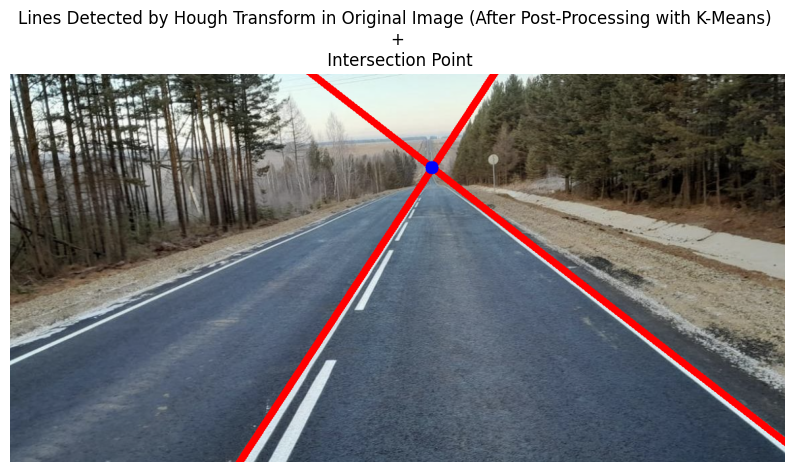

In [28]:
show_image(out_image, title="Lines Detected by Hough Transform in Original Image (After Post-Processing with K-Means) \n+\n Intersection Point")

In [ ]:
out_image = cv2.cvtColor( out_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("assets/road1_out.png", out_image)

True